In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow: {}".format(tf.VERSION))

Tensorflow: 1.9.0


Now we'll load the dataset and inspect it a little - I have two approaches in mind, both of which involve scaling pixel intensities down to [0, 1]:
1) Threshold pixel classes at 0.5 - <0.5 is white, >0.5 is black
2) Treat the pixel intensities as the likelihood of activation

Training samples:  60000
Training set shape:  (60000, 28, 28)
Test cases:  10000
Training shape:  (28, 28)


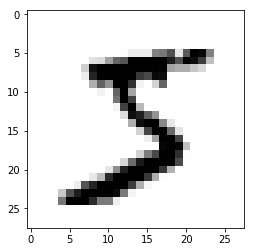

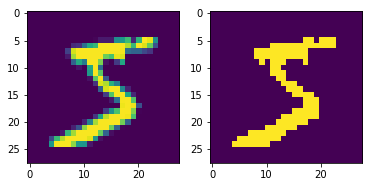

In [2]:
train, test = tf.keras.datasets.mnist.load_data(path="mnist.npz")

# Quick check on the sizes of the datasets
print("Training samples: ", len(train[0]))
print("Training set shape: ", train[0].shape)
print("Test cases: ", len(test[0]))

# Checking the size of each sample
print("Training shape: ", train[0][0].shape)

# print(train[0][0]) -- examining the values; 0-255

# Checking out a sample
image = train[0][0]
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

# Copying the sample, thresholding activations at >0.5 == 1, <0.5 == 0
example = train[0][0]
example = example / 255.0

for i, x in enumerate(example):
    for j, y in enumerate(x):
        if y < 0.5:
            example[i][j] = 0
        else:
            example[i][j] = 1

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(image)
axarr[1].imshow(example)

In [16]:
class RBM():
    def __init__(self, v_units=784, h_units=200, k_steps=35):
        self.num_visible = v_units # visible units
        self.num_hidden = h_units # hidden units
        self.k_steps = k_steps # k-steps for contrastive divergence
        
        self.alpha = tf.Variable(0.1) # learning rate
        
        # RBM architecture will be two layers only - visible and hidden, none else; not a DBM
        self.weights = tf.Variable(tf.truncated_normal(shape=[self.num_visible, self.num_hidden], stddev=0.1), name='weights')
        self.v_biases = tf.Variable(tf.constant(1.0, shape=[self.num_visible]), name='visible_biases')
        self.h_biases = tf.Variable(tf.constant(1.0, shape=[self.num_hidden]), name='hidden_biases')
        
    def vhActivation(self, visible):
        # We use the result of sigmoid activation as the probability of neuron firing
        input = tf.matmul(visible, self.weights) + self.h_biases
        return tf.nn.sigmoid(input)
    
    def hvActivation(self, hidden):
        # Same case, in reverse
        input = tf.matmul(hidden, tf.transpose(self.weights)) + self.v_biases
        return tf.nn.sigmoid(input)
    
    # Two following functions are Gibbs sampling steps
    # To simulate the firing of stochastic binary neurons, we make use of tf.random_uniform
    # which generates random vals between [0, 1) for floats. As they are random,
    # we don't know which are larger/smaller than the sigmoid activations.
    # So we subtract them from the sigmoid activations and then use ReLU to decide which neurons have fired 'stochastically'
    # and which haven't. tf.sign raises the values that would survive to 1, and drops the losing neurons to -1 to be culled by ReLU
    def sample_h(self, v_sample):
        h = self.vhActivation(v_sample)
        h_sample = tf.nn.relu(tf.sign(h - tf.random_uniform(tf.shape(h))))
        return h_sample
    
    def sample_v(self, h_sample):
        v = self.hvActivation(h_sample)
        v_sample = tf.nn.relu(tf.sign(v - tf.random_uniform(tf.shape(v))))
        return v_sample
    
    # CDk learning algorithm
    def CD_k(self, v):
        # sample with k steps of Gibbs
        v_sample = v
        h_sample = self.sample_h(v_sample) # generating the first step in the Markov chain from time t=0
        
        for step in range(self.k_steps): # subsequent time steps in the Markov chain progress now for k steps
            v_sample = self.sample_v(h_sample)
            h_sample = self.sample_h(v_sample)
        
        # The learning rule is ΔW = ε(<vh>0 - <vh>k)
        # in <vh>0, v is the visible vector at the beginning of the Markov particle, h is sample generated given that v.
        # in <vh>k, the last sampling taken from the chain, v and h are both final samples generated from the chain
        h = self.vhActivation(v)
        positive_statistic = tf.matmul(tf.transpose(v), h) # wish to increase probability of the visible vector
        negative_statistic = tf.matmul(tf.transpose(v_sample), h_sample) # decrease probabilities of competing vectors
        w_grad = (positive_statistic - negative_statistic) / tf.to_float(tf.shape(v)[0])
        
        # in keeping with the guides I'm following, I'll perform these next two steps.
        # They look to be gradients for the biases
        hb_grad = tf.reduce_mean(h - h_sample, 0)
        vb_grad = tf.reduce_mean(v - v_sample, 0)
        
        return w_grad, hb_grad, vb_grad
    
    def learning_step(self, v):
        w_grad, hb_grad, vb_grad = self.CD_k(v)
        
        w = tf.assign(self.weights, self.alpha * w_grad)
        hb = tf.assign(self.h_biases, self.alpha * hb_grad)
        vb = tf.assign(self.v_biases, self.alpha * vb_grad)
        return [w, vb, hb]
    
    # function to get samples of reconstructed images from the model
    # run for a number of steps to approach the stationary distribution of the model
    # then return a reconstruction to display
    def imageSample(self, v, steps=5000):
        v_sample = v
        # Run chain for 'steps' iterations before taking a sample - default is 5000 steps
        for step in range(steps):
            v_sample = self.sample_v(self.sample_h((v_sample)))
        return v_sample
    
    # Functions for calculating likelihood now follow
    # Our objective function is to maximize the likelihood of visible vectors from the dataset
    # while reducing the likelihood of competitor vectors
    # to track this, we try to quantify the log probabilities
    # but because the amount of join configurations of (v, h) vary exponentially with the number of units,
    # we compute approximations instead; pseudo likelihood.
    def free_energy(self, v):
        # (1 x num_visible) * (num_visible x 1) -> real value output
        print(v.get_shape())
        print(self.v_biases.get_shape())
        visible_activations = tf.matmul(v, tf.reshape(self.v_biases, [tf.shape(self.v_biases)[0], 1]))
        # visible activations took care of energy contributions from the visible units and their biases
        # activations within the hidden layer, including visible-hidden contributions, are exponentiated
        # and marginalized in the logarithmic domain
        activations = tf.reduce_sum(tf.log(1 + tf.exp(self.h_biases + tf.matmul(v, self.weights))), axis=1)
        return -(visible_activations - activations)
    
    i = 0
    
    def pseudo_log_likelihood(self, v):
        vec = tf.round(v)
        vec_fe = self.free_energy(vec)
        split0, split1, split2 = tf.split(vec, [self.i, 1, tf.shape(vec)[1] - self.i - 1], 1)
        veci = tf.concat([split0, 1 - split1, split2], 1)
        self.i = (self.i + 1) % self.num_visible
        veci_fe = self.free_energy(veci)
        return tf.reduce_mean(self.num_visible * tf.log(tf.nn.sigmoid(veci_fe - vec_fe)), axis=0)

In [25]:
import random

def trainRBM(training_data, test_data, epochs):
    
    data = np.float32(np.reshape(training_data, [60000, 784]))
    
    x = tf.placeholder(tf.float32, [None, 784])
    
    rbm = RBM()
    rbm.alpha = 0.1
    
    step = rbm.learning_step(x)
    sampler = rbm.imageSample(x)
    pl = rbm.pseudo_log_likelihood(x)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        mean_cost = [] # averaging cost over 500 epochs
        for i in range(epochs):
            cost = sess.run(pl, feed_dict={x: data} )
            mean_cost.append(cost)

            # draw a sample every 500 epochs
            if i % 500 == 0:
                sample = sess.run(sampler, feed_dict = {x: data})
                sample = sample[random.randrange(59999)].reshape([28, 28])
                plt.imshow(sample, cmap=plt.get_cmap('gray_r'))
                print('Epoch ', i+1, ', Cost: ', np.mean(mean_cost))
                mean_cost = []

        print('Test data')
        testCase = random.randrange(9999)
        sample = sess.run(sampler, feed_dict = {x: test_data[testCase]})
        sample = sample.reshape([28, 28])
        plt.title("Label: %d" % test[1][testCase])
        plt.imshow(sample)
        plt.show()
        

In [24]:
trainRBM(train[0], test[0], 3000)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18